In [53]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set(style="white")

In [38]:
output_file = 'results/ResSelNet/results_pollution_0523_crossval'

total_metrics = pd.read_csv(f'{output_file}.csv')

total_metrics["n_features"] = total_metrics.selected_features.apply(eval).apply(len)

In [39]:
total_metrics['model_name'] = total_metrics['model_name'].replace({'decisiontree': 'DT', 'lstm': "LSTM"})
total_metrics['selection_name'] = total_metrics['selection_name'].replace({'NoSelection': 'NS', 'TimeSelectionLayer': 'TSL'})

total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='LSTM') & (total_metrics.selection_params_residual==False), 'model_name'] = 'TLSTM'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='dense') & (total_metrics.selection_params_residual==False), 'model_name'] = 'TFF'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='LSTM') & (total_metrics.selection_params_residual==True), 'model_name'] = 'TLSTMRes'
total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.model_name=='dense') & (total_metrics.selection_params_residual==True), 'model_name'] = 'TFFRes'
total_metrics.loc[total_metrics.selection_name=='TimeSelectionLayerConstant', 'model_name'] = 'TSL*'
#total_metrics.loc[(total_metrics.selection_name=='TSL') & (total_metrics.selection_params_residual), 'model_name'] = 'TSLRes'
total_metrics['model_name'] = total_metrics['model_name'].replace({'dense': 'FF', 'lasso': 'L1'})
total_metrics['dataset'] = total_metrics['dataset'].apply(lambda x: x.capitalize()).replace({'Rondadelvalle': 'Ronda del valle'})
total_metrics.drop("dataset_name", inplace=True, axis=1)

In [46]:
best_models = total_metrics.loc[total_metrics.groupby(['dataset','dataset_params_test_year', 'model_name'], dropna=False).root_mean_squared_error_valid.idxmin()]
best_models[best_models.dataset_params_test_year>2005].pivot(index = ['dataset_params_test_year'], columns=['dataset', 'model_name'], values=['root_mean_squared_error', 'n_features']).round(1).to_excel("results/ResSelNet/results_pollution_0523_crossval.xlsx")

<Figure size 2000x2000 with 0 Axes>

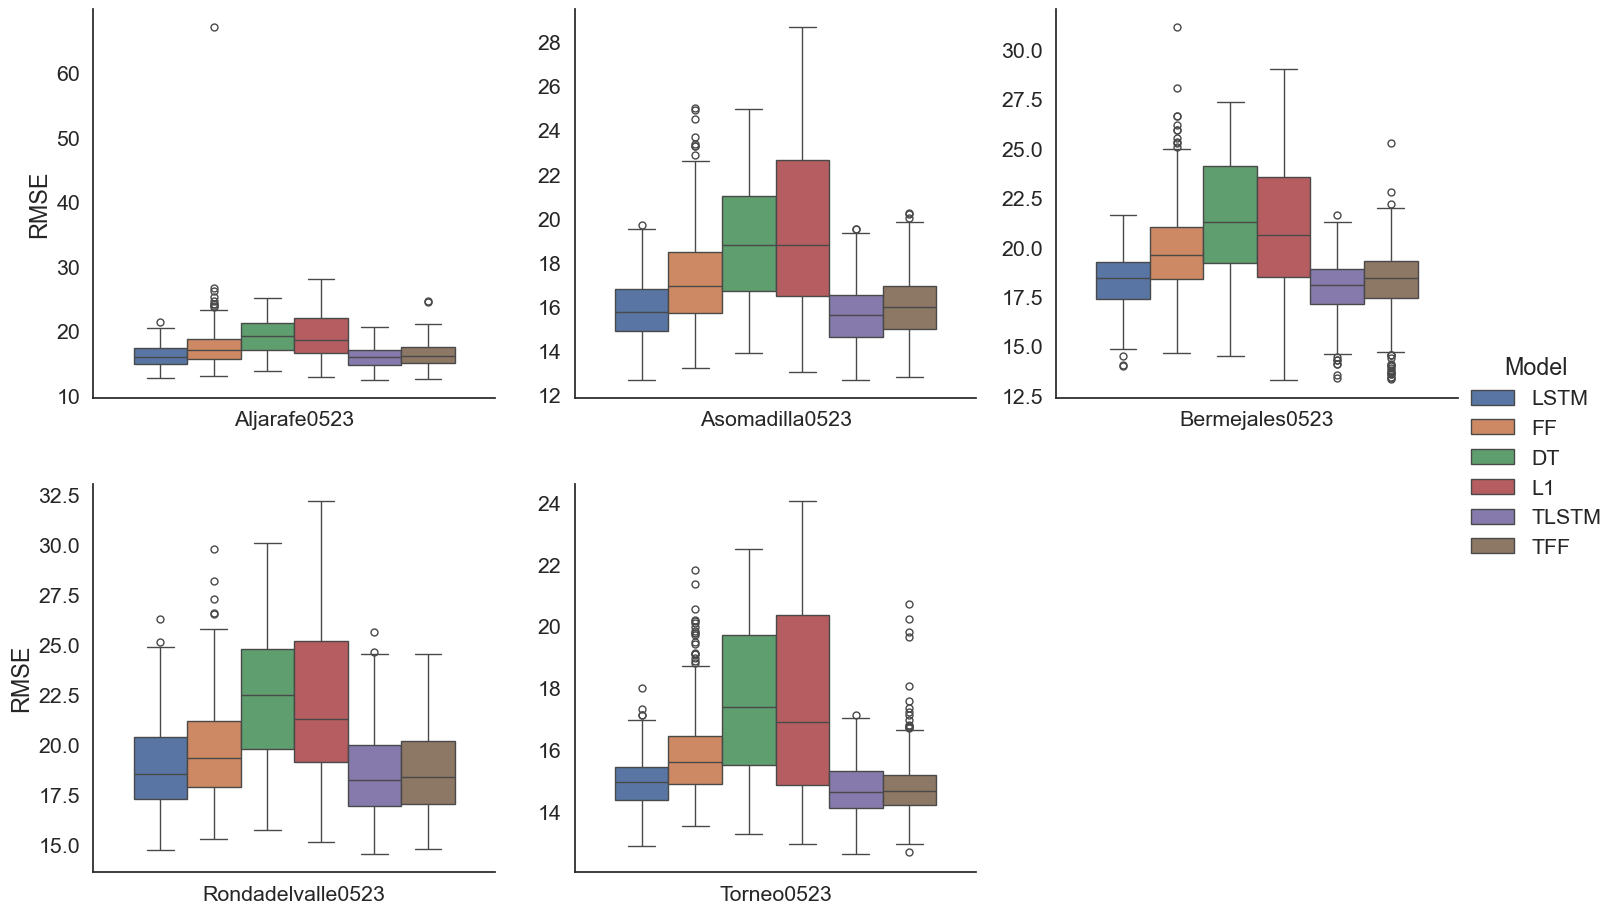

In [50]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
#total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)
total_metrics = total_metrics.rename({'model_name': 'Model', 'root_mean_squared_error': 'RMSE', 'n_features': '# Features'}, axis=1)
g = sns.catplot(data=total_metrics, kind='box', x='dataset', y="RMSE", col='dataset', hue='Model', sharex=False, sharey=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.show()

<Figure size 2000x2000 with 0 Axes>

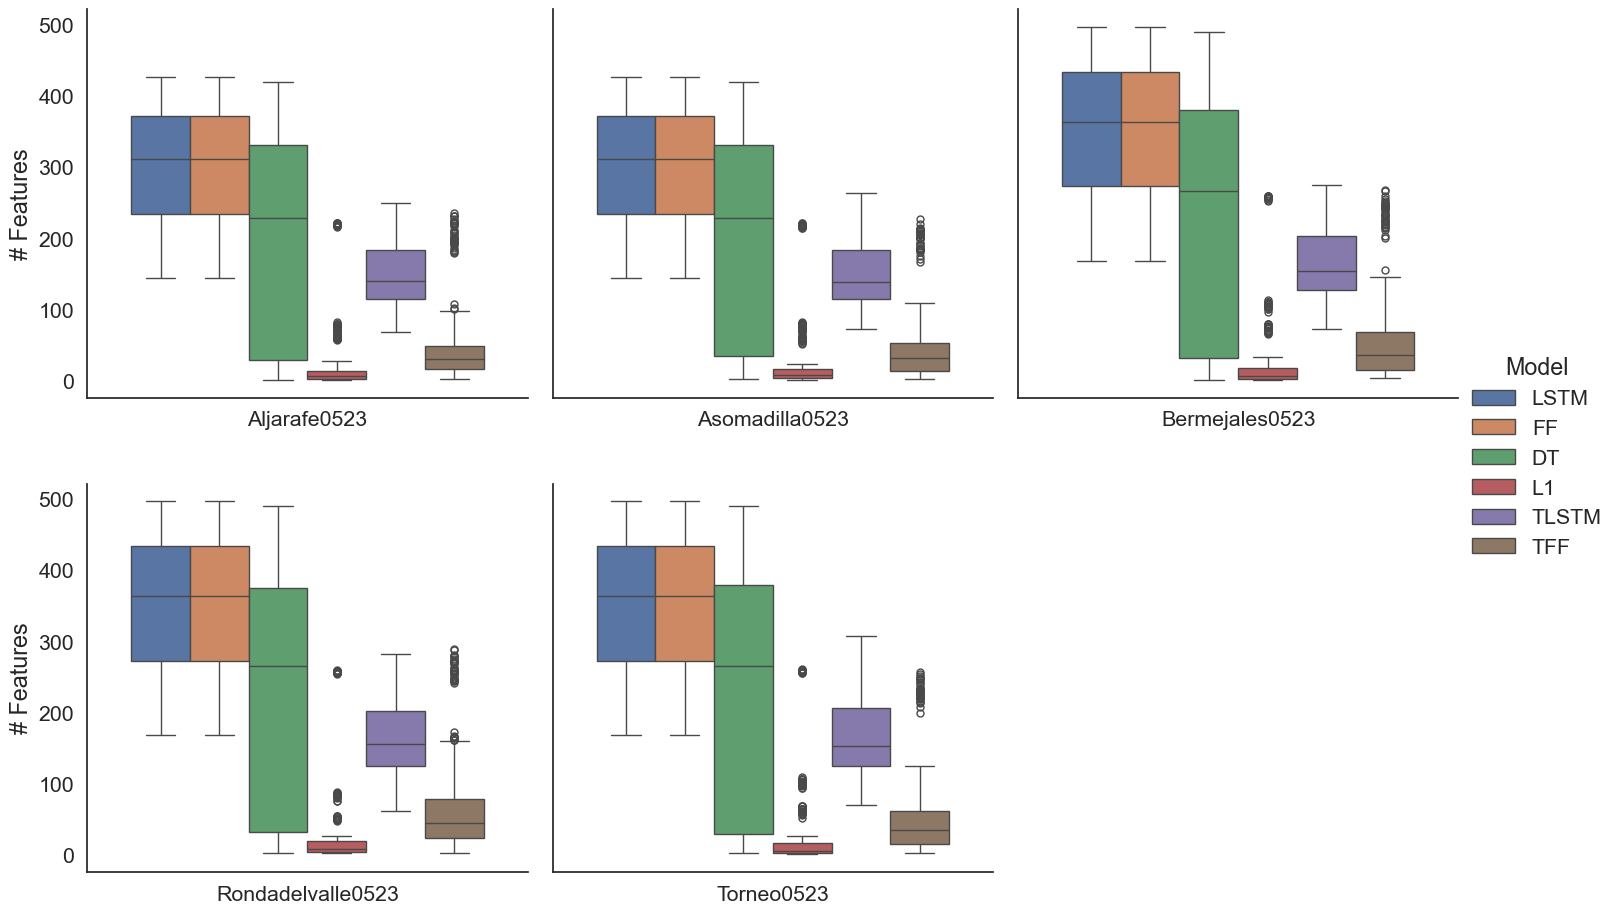

In [52]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(20,20))
total_metrics.loc[:, 'selection_params_residual'] = total_metrics.loc[:, 'selection_params_residual'].fillna(False)

g = sns.catplot(data=total_metrics[(total_metrics.dataset_params_test_year>2005)], kind='box', x='dataset', y="# Features", col='dataset', hue='Model', sharex=False, col_wrap=3, legend=True)#.set_yscale("log")
g.set(xlabel=None)
g.set_titles(template='')
plt.show()
plt.show()

## Selection masks

0.5333333333333333
0.49765258215962443
0.5435897435897435
0.568075117370892
0.5422535211267606


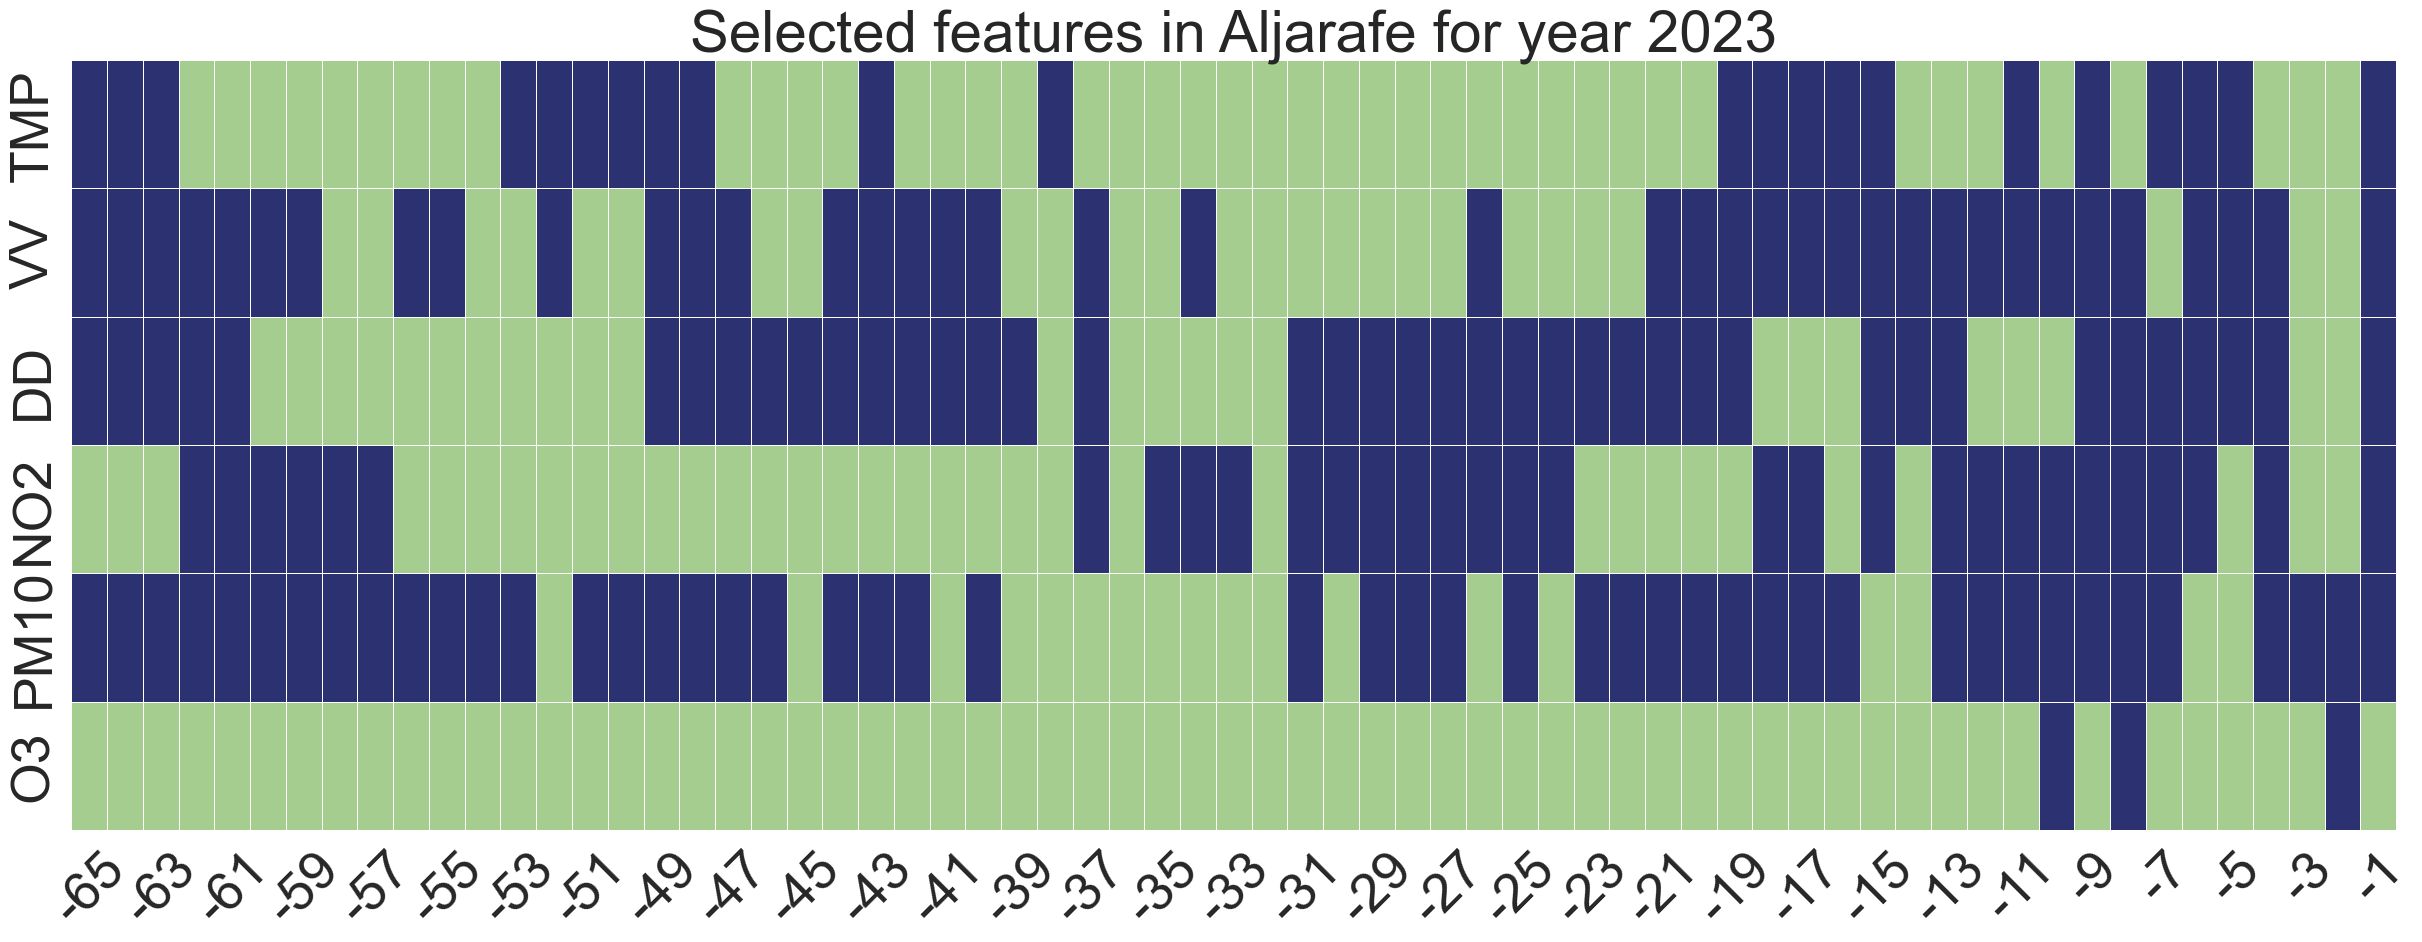

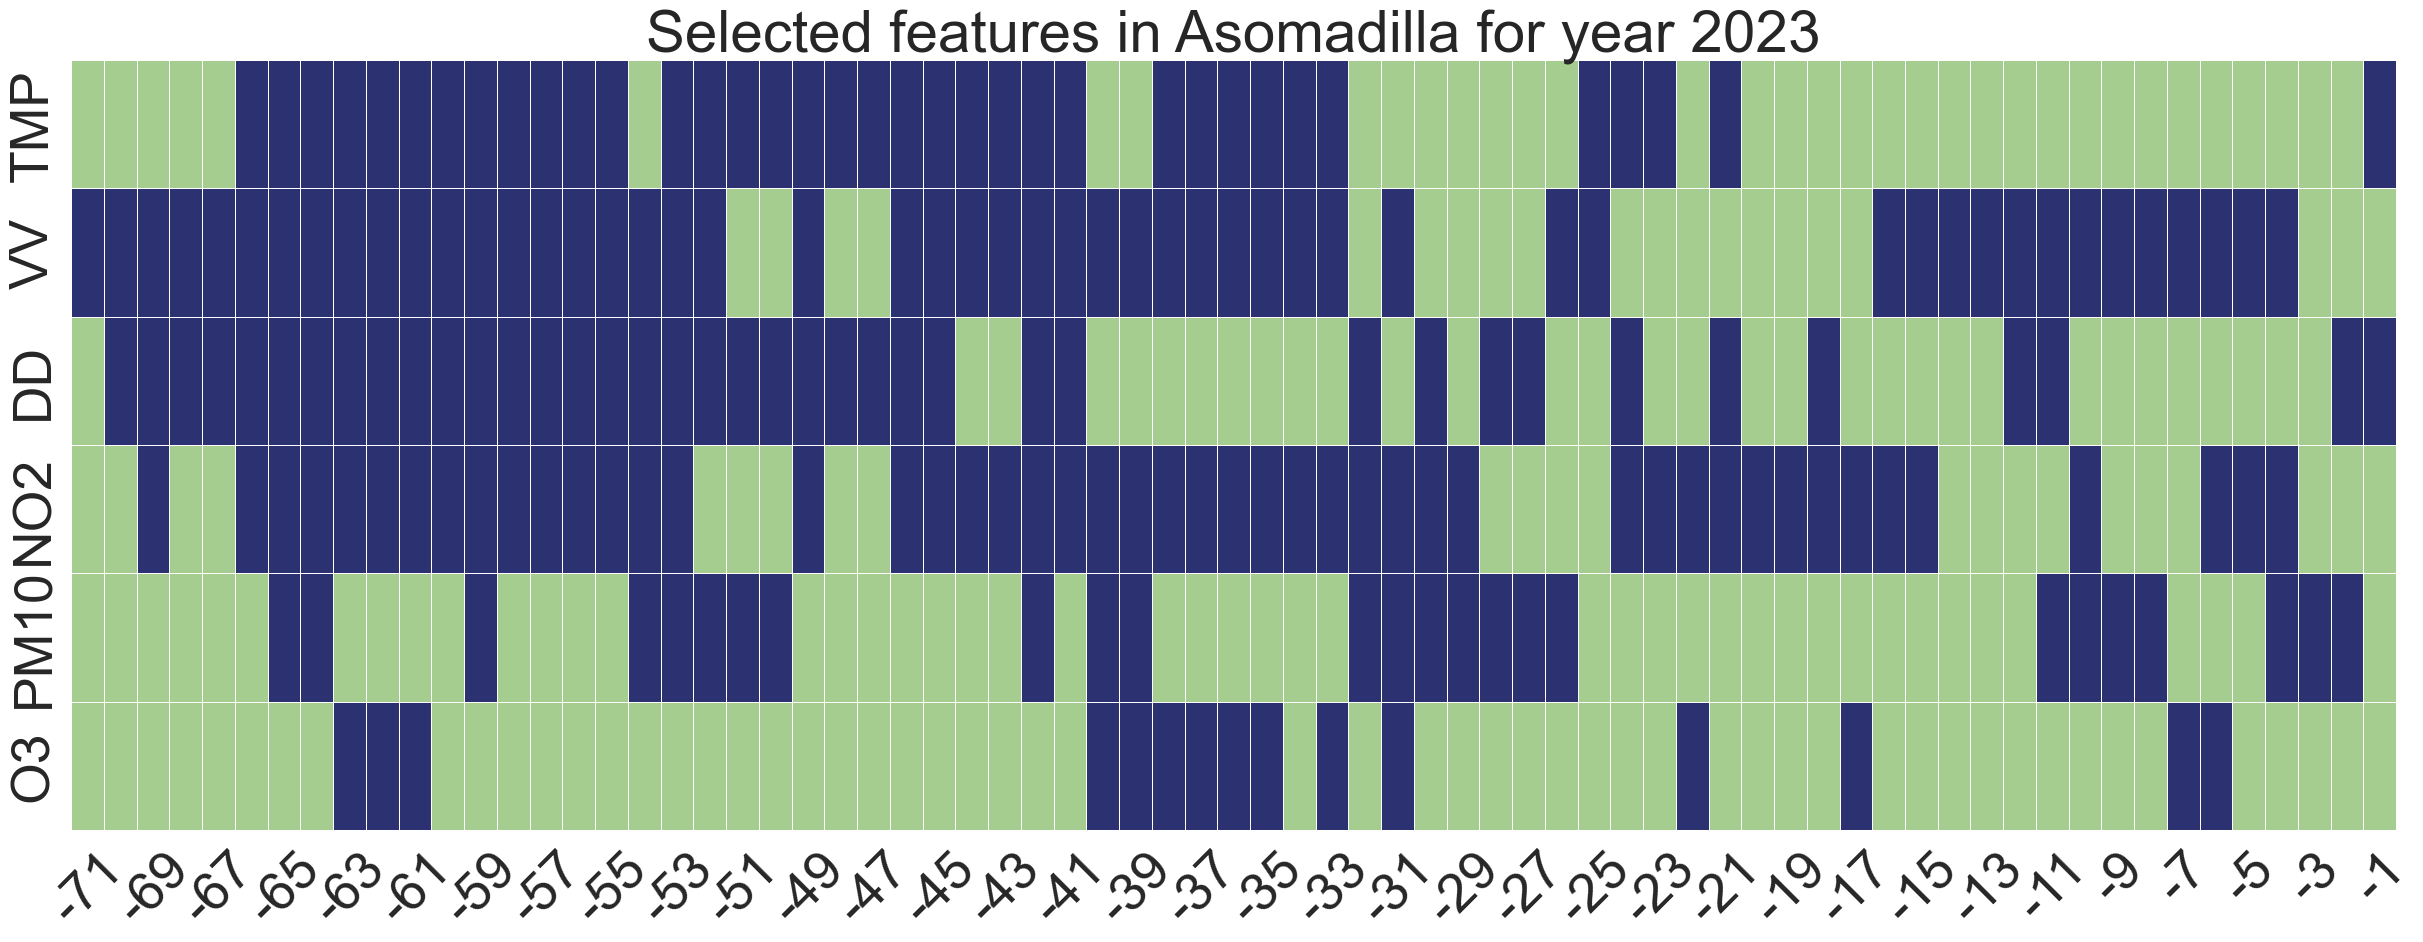

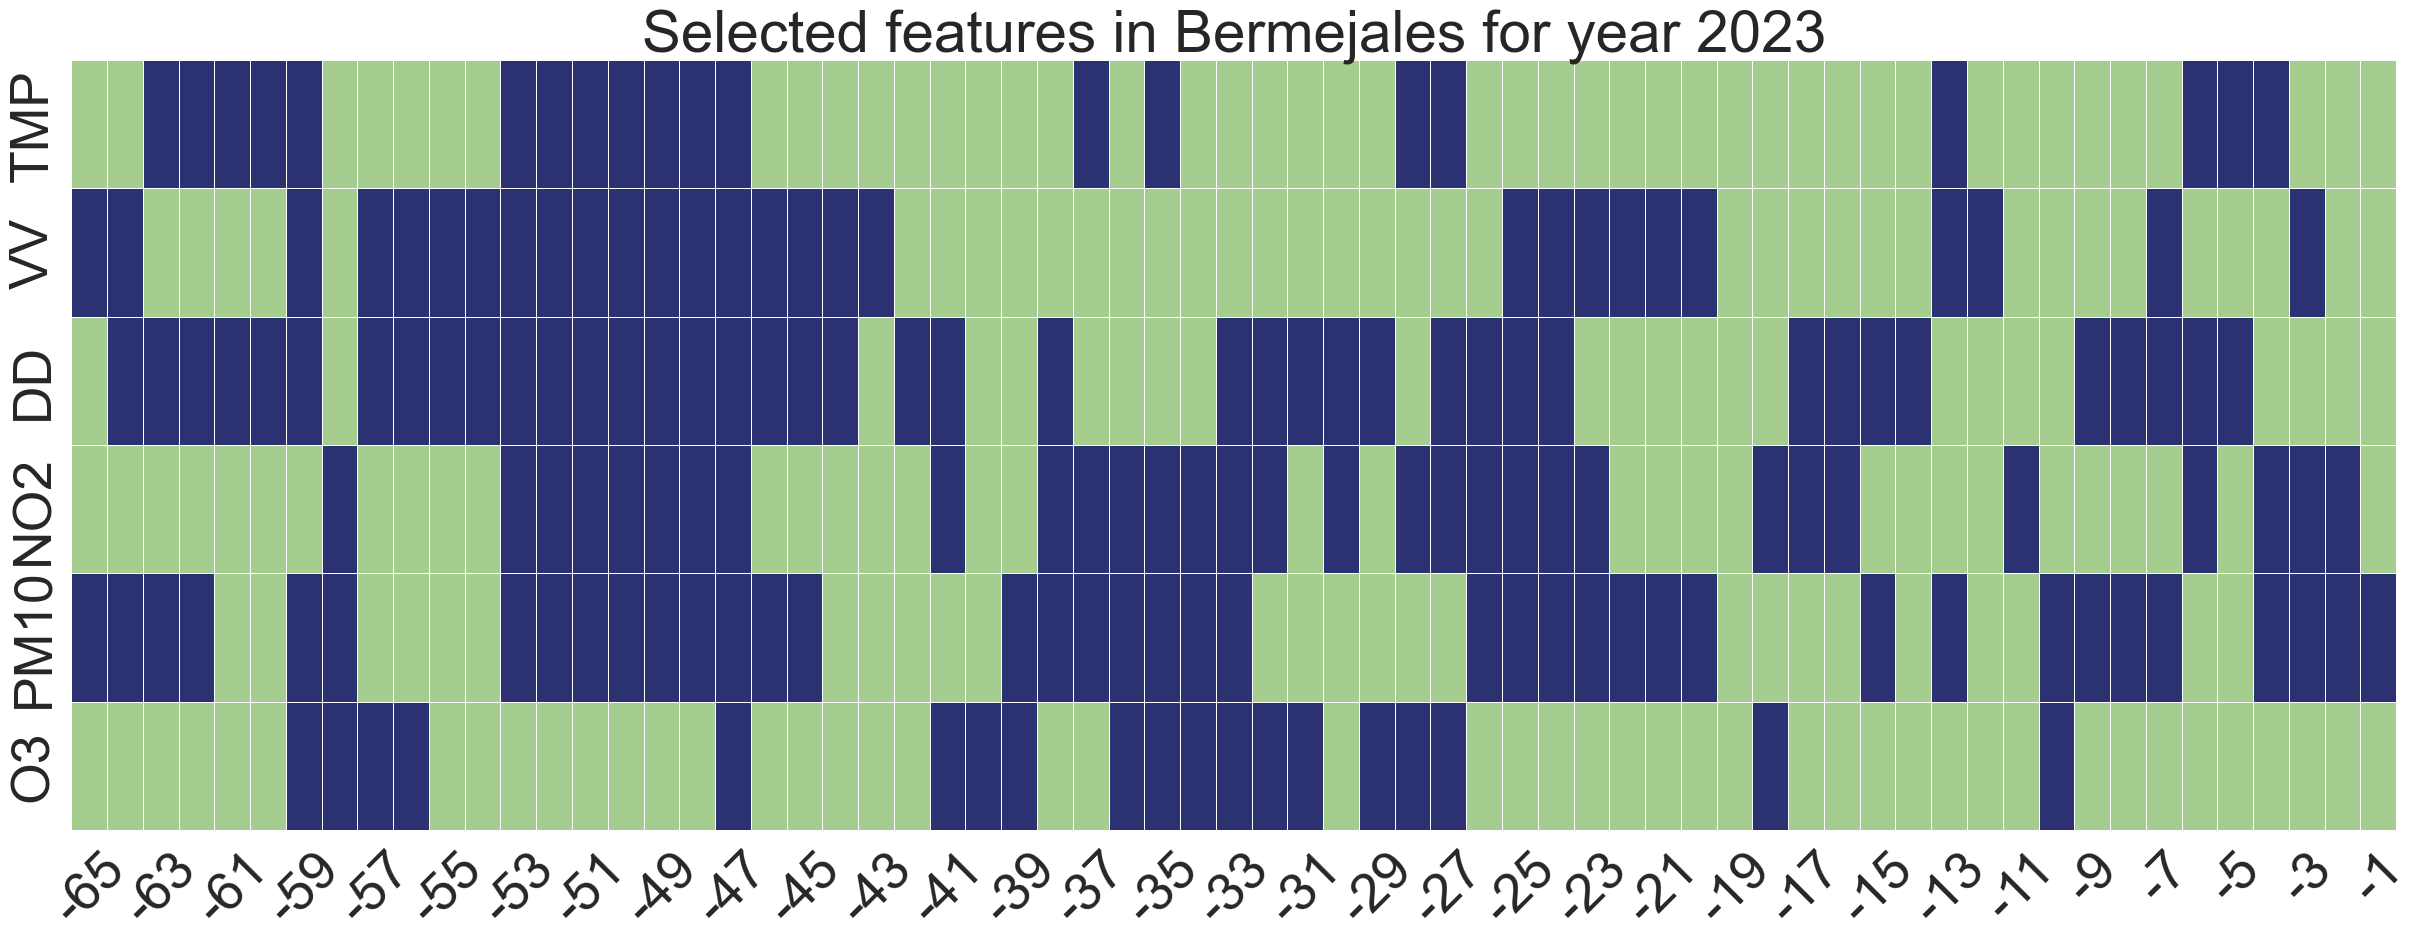

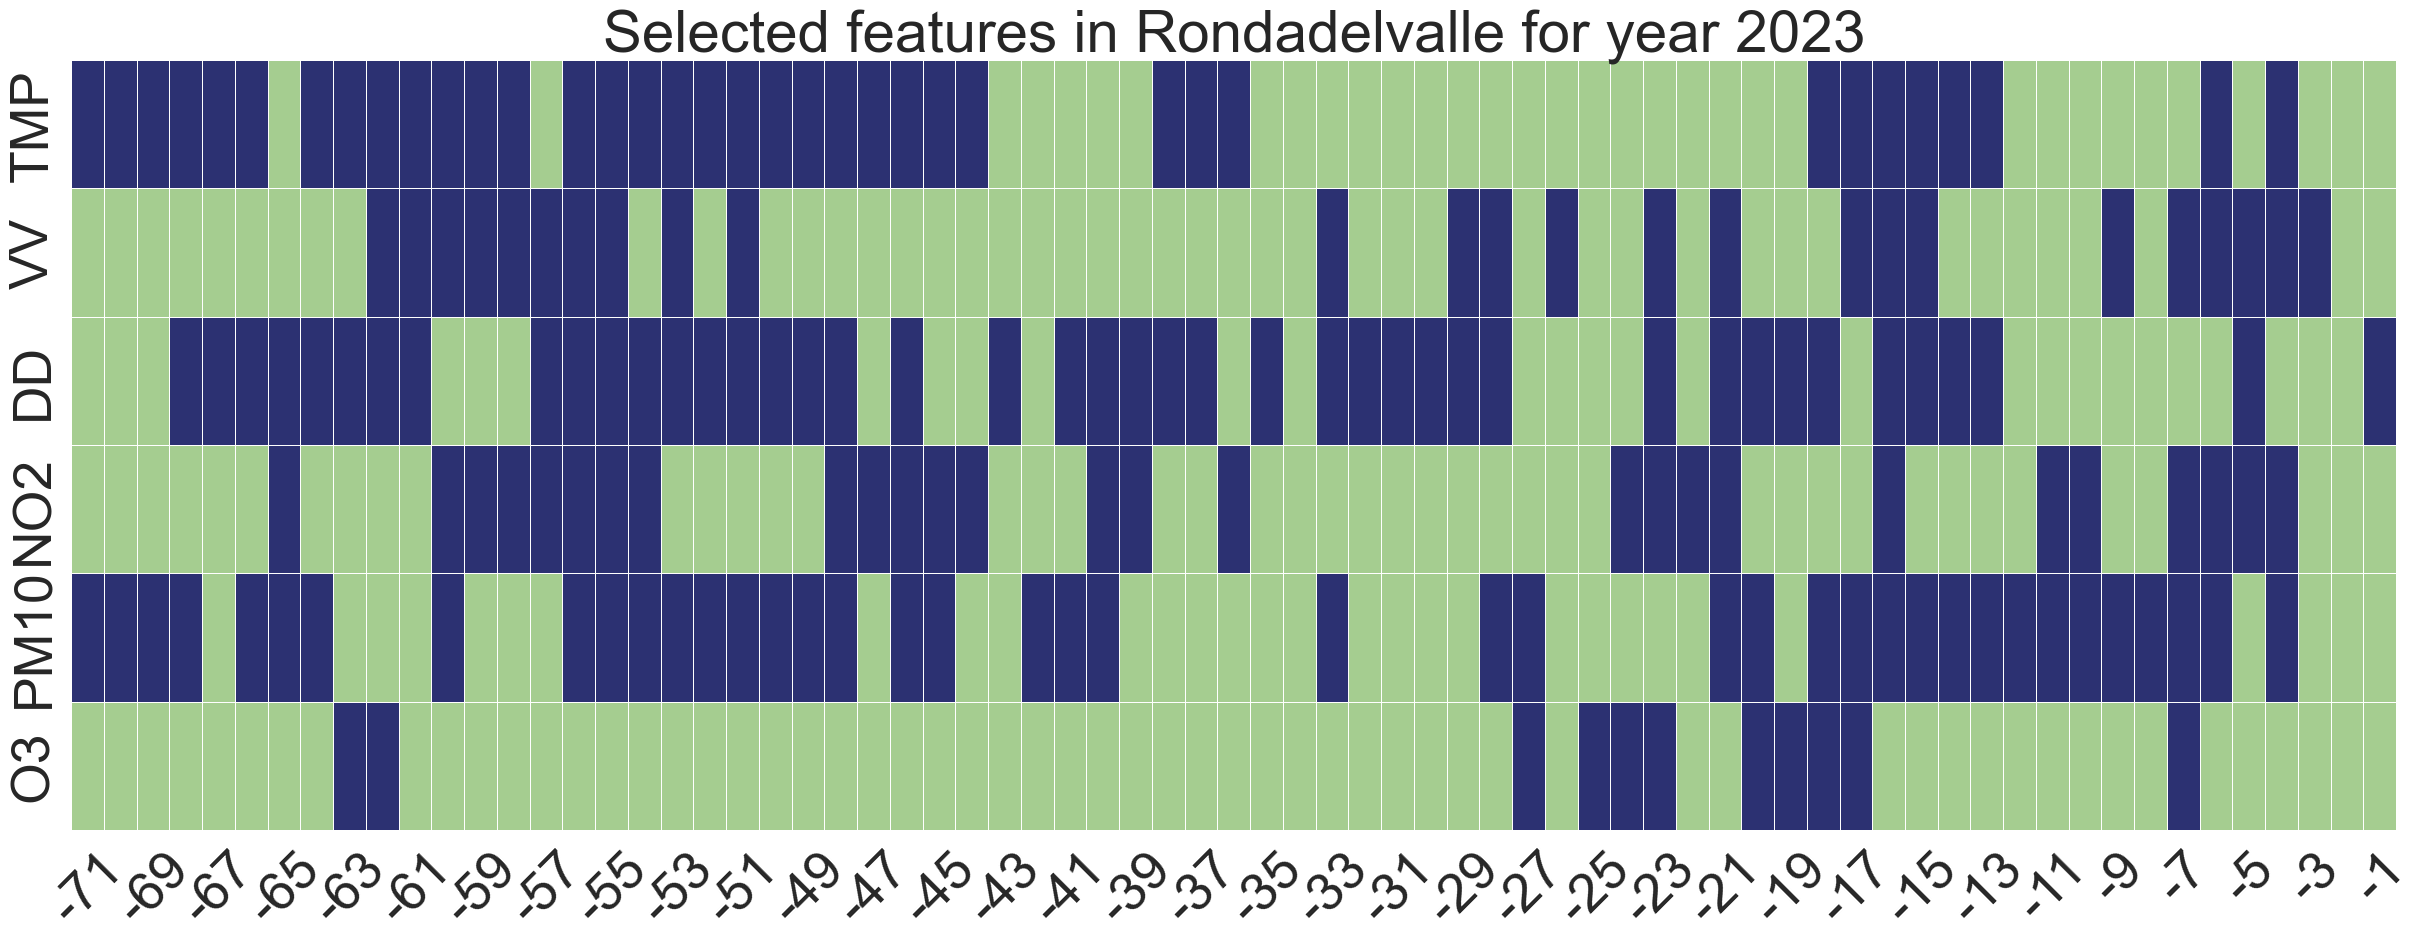

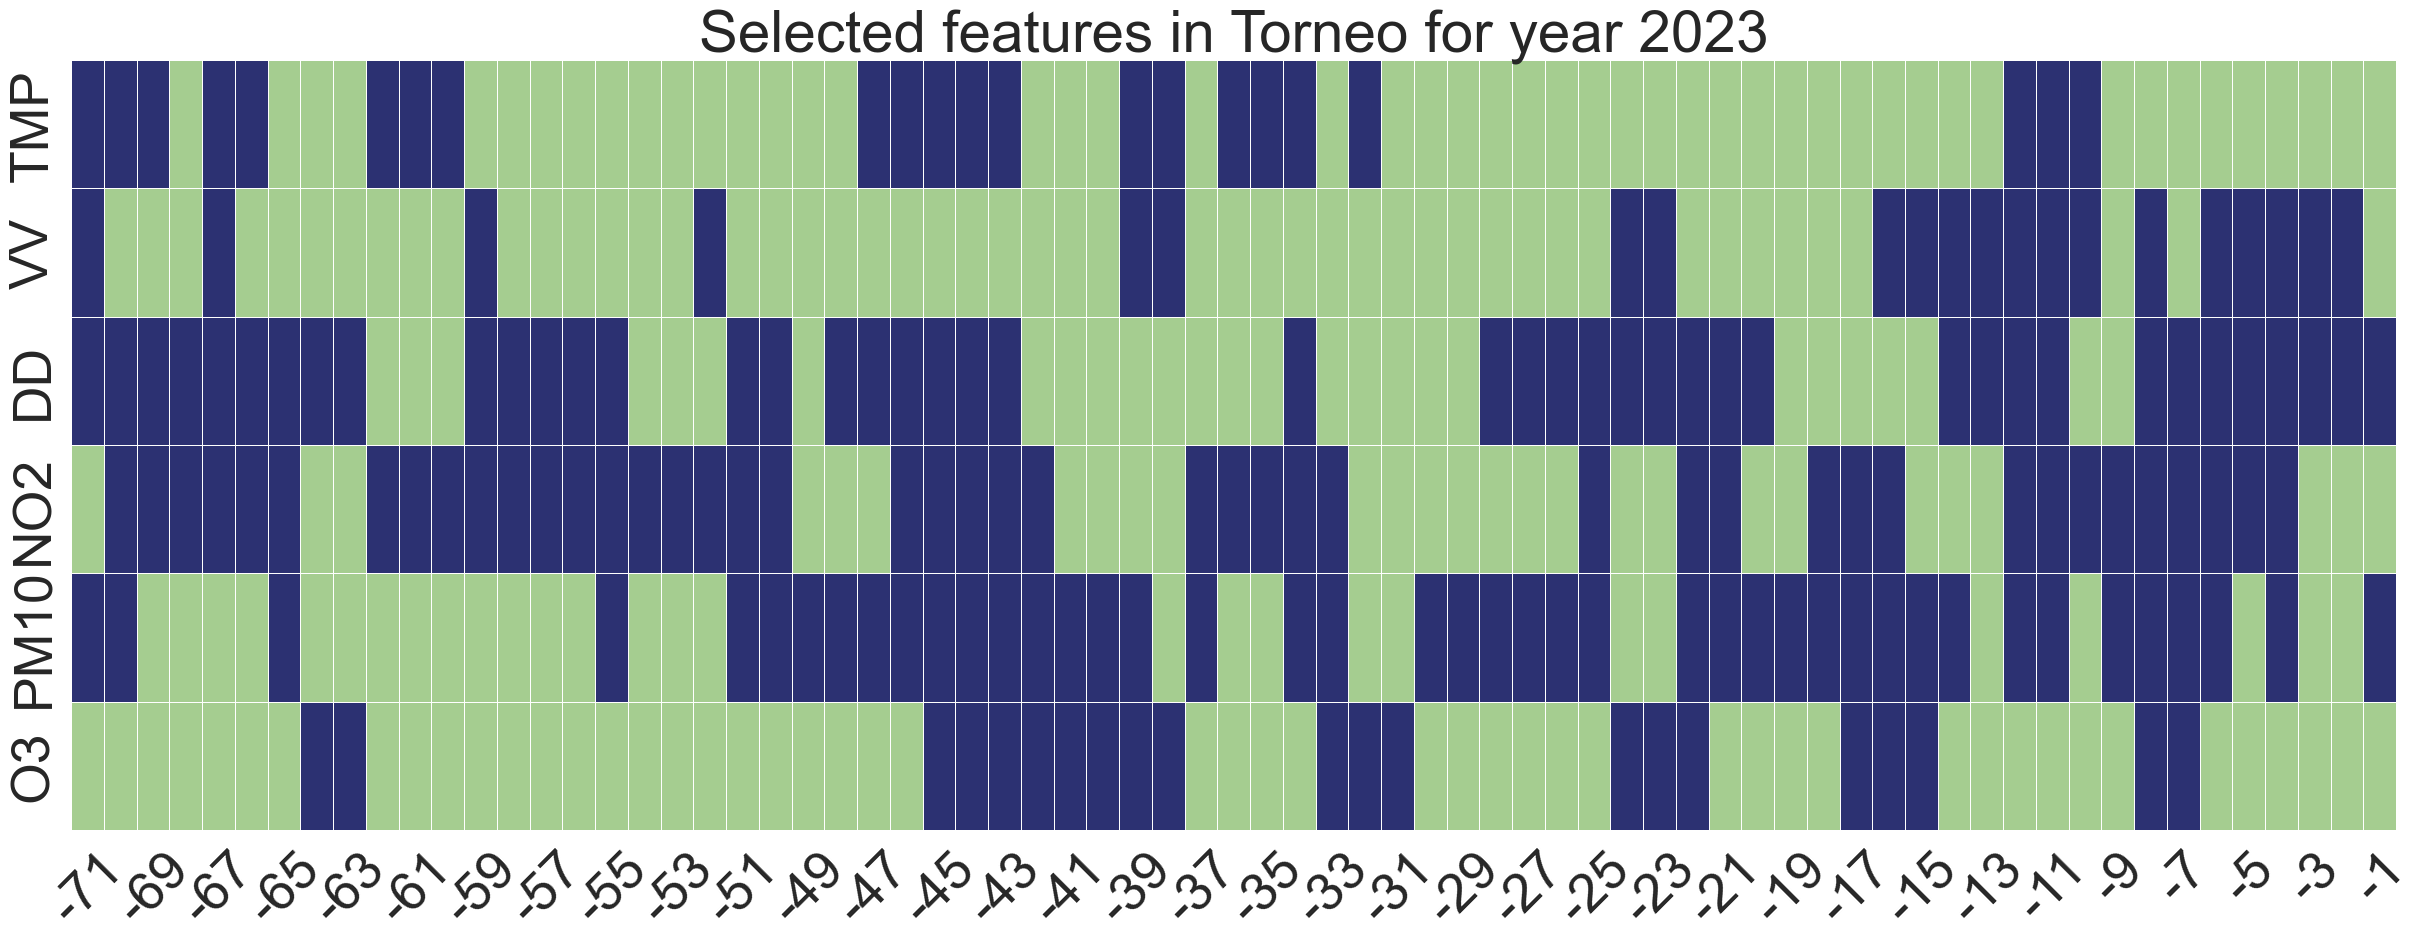

In [56]:
sns.set(font_scale=3.5)


fetures_list = ['tmp', 'vv', 'dd', 'no2', 'pm10', 'o3']
for dataset in best_models.dataset.unique():
    results_tsl_dataset = best_models[(best_models.dataset==dataset) & (best_models.model_name=='TLSTM')].sort_values('dataset_params_test_year')
    results_tsl_dataset1 = best_models[best_models['dataset_params_test_year']==2023]
    features = results_tsl_dataset.features.apply(eval).apply(np.array).values[0]
    selected_features = results_tsl_dataset.selected_features.apply(eval).apply(np.array).values[0]

    selection_masks = []
    for feat in fetures_list:
        
        feats = features[np.core.defchararray.find(features, feat)!=-1]
        if len(feats)==0:
            continue
        sfeats = selected_features[np.core.defchararray.find(selected_features, feat)!=-1]

        
        mask = np.isin(feats, sfeats).astype(np.uint)
        selection_masks.append(mask)
    
    selection_masks = np.stack(selection_masks)
    print(selection_masks.sum()/(selection_masks.shape[0]*selection_masks.shape[1]))
    fig, ax = plt.subplots(figsize=(30,10))

    ax.set_title(f'Selected features in {dataset[:-4]} for year 2023')
    cmap = sns.cm.crest_r
    feats[-2::-2] = ''
    g = sns.heatmap(selection_masks, yticklabels=list(map(lambda x: x.upper(), fetures_list)),cmap=cmap, xticklabels=list(map(lambda f: f.replace('target_o3 t', ''), feats.tolist())), cbar=False, linewidth=.5, ax=ax)
    plt.xticks(rotation=45)
    fig = g.get_figure()
    fig.savefig(f"figures/SelectionMasks/Ozone_{dataset}.png", bbox_inches='tight') 

## Results by year

In [59]:
best_metrics = best_models.rename({'dataset_params_test_year': 'year'}, axis=1)
best_metrics = best_metrics[(best_metrics.year>2005)]
best_metrics = best_metrics[best_metrics.model_name.isin(["L1", "TFF", "TLSTM"])]
best_metrics.pivot(index = ['year'], columns=[ 'dataset','model_name'], values='root_mean_squared_error').round(1)#.to_latex()

dataset    Aljarafe0523             Asomadilla0523             Bermejales0523  \
model_name           L1   TFF TLSTM             L1   TFF TLSTM             L1   
year                                                                            
2006               16.8  17.1  16.2           17.4  17.7  17.1           18.0   
2007               15.5  16.4  15.6           16.4  16.3  16.2           17.7   
2008               16.7  17.7  16.9           16.6  16.9  16.3           18.6   
2009               16.6  16.9  16.7           16.2  15.8  15.8           18.7   
2010               16.9  16.6  16.1           16.3  15.9  15.6           18.5   
2011               15.0  16.0  14.8           15.8  15.9  16.2           17.0   
2012               16.5  16.7  16.0           15.8  15.7  15.6           17.4   
2013               14.9  14.4  14.2           14.6  14.4  14.7           17.2   
2014               15.0  15.0  14.4           15.6  15.1  14.8           16.7   
2015               17.2  16.1  16.0           14.9  14.9  14.8           16.4   
2016               15.1  15.1  14.4           14.7  14.5  14.4           16.3   
2017               15.2  15.1  14.5           14.8  15.1  15.2           17.2   
2018               14.1  14.3  13.9           15.2  14.7  14.2           17.5   
2019               13.7  13.8  14.0           15.1  14.6  14.6           16.9   
2020               13.1  13.0  12.8           13.6  13.6  13.1           16.1   
2021               12.9  12.9  13.1           14.1  13.7  14.1           16.2   
2022               13.6  13.7  13.3           13.0  15.7  12.7           15.5   
2023               15.2  15.2  14.6           13.6  13.3  13.3           14.0   

dataset                Rondadelvalle0523             Torneo0523              
model_name   TFF TLSTM                L1   TFF TLSTM         L1   TFF TLSTM  
year                                                                         
2006        18.9  18.7              20.3  20.3  19.8       13.1  13.1  12.9  
2007        18.3  17.9              19.9  19.6  19.4       13.0  13.1  13.0  
2008        19.2  18.5              20.0  19.3  19.1       13.1  13.2  13.2  
2009        18.6  18.7              18.6  18.4  18.1       13.5  13.7  14.4  
2010        18.9  18.1              20.5  19.8  19.2       14.4  14.4  14.1  
2011        17.6  17.4              18.2  17.8  17.6       13.6  13.9  13.7  
2012        17.8  17.6              16.4  15.5  15.8       14.3  14.4  14.5  
2013        17.2  16.7              17.2  16.7  16.1       13.7  13.7  13.5  
2014        16.8  16.3              17.8  16.9  16.5       13.8  14.0  13.9  
2015        16.6  16.7              18.1  17.1  16.5       14.2  14.0  14.4  
2016        16.5  16.1              17.8  16.8  16.5       14.2  13.6  13.7  
2017        17.8  17.2              19.2  18.1  17.7       14.6  14.2  14.1  
2018        18.1  17.7              18.5  17.8  16.7       14.5  14.0  14.0  
2019        17.3  16.8              17.0  16.8  16.4       14.8  14.5  14.3  
2020        15.8  15.2              15.1  14.8  14.6       13.7  13.5  13.9  
2021        15.7  15.9              16.7  16.1  15.4       14.2  14.4  14.1  
2022        14.9  14.7              16.3  15.4  15.6       14.3  14.4  14.3  
2023        13.4  14.3              16.3  15.6  15.4       14.0  14.3  14.3

## Bayesian tests

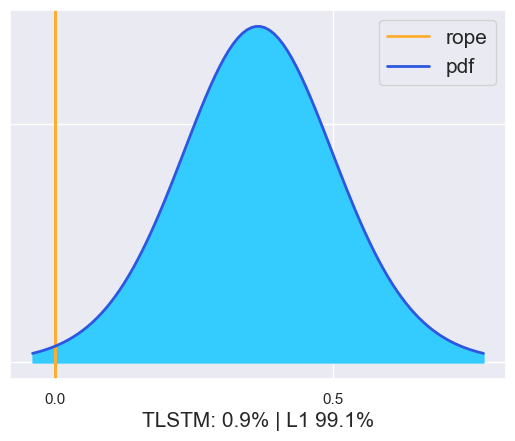

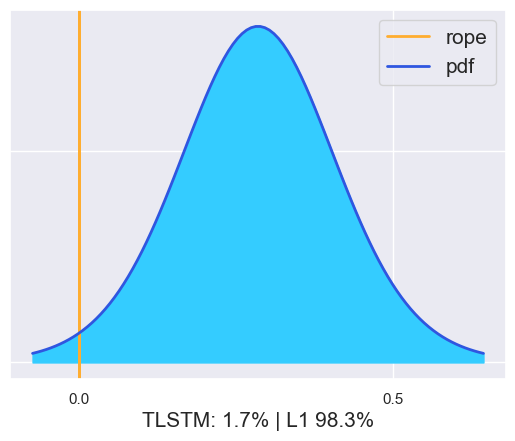

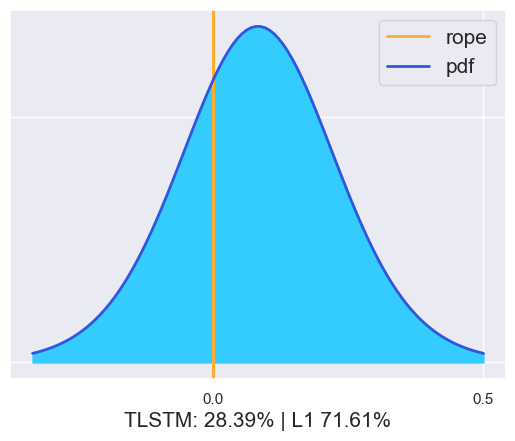

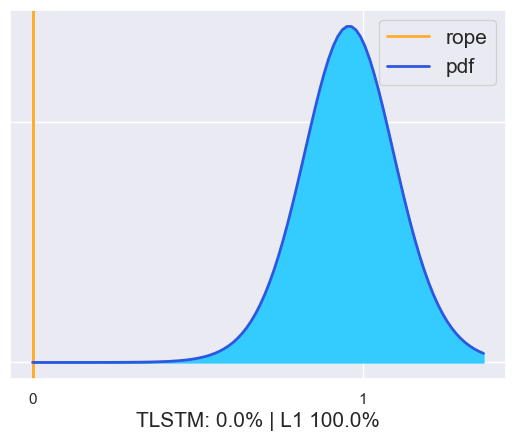

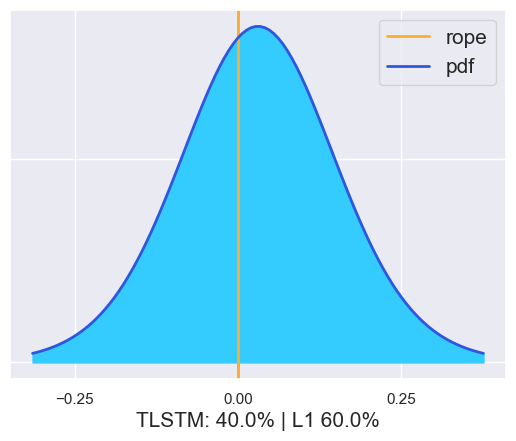

In [61]:
from baycomp import two_on_single


for dataset in best_metrics.dataset.unique():
    metrics_tsl = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='TLSTM')].root_mean_squared_error.values
    metrics_l1 = best_metrics[(best_metrics.dataset==dataset) & (best_metrics.model_name=='L1')].root_mean_squared_error.values
    probs, fig = two_on_single(metrics_tsl, metrics_l1, names=['TLSTM', 'L1'], plot=True)
    plt.xlabel(f'TLSTM: {round(probs[0]*100, 2)}% | L1 {round(probs[1]*100, 2)}%', fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig(f"figures/Baytest/Baytest{dataset}.png") 

## Best hyperparameters

In [62]:
best_hyperparameters = best_models.reset_index().groupby(['dataset', 'model_name']).head(1).reset_index()

In [66]:
pd.set_option('display.max_colwidth', 2000)
params = list(map(lambda my_dict: {k: my_dict[k] if not my_dict[k].is_integer() else int(my_dict[k]) for k in my_dict if not np.isnan(my_dict[k])},best_hyperparameters.loc[:, ['model_params_layers', 'model_params_units', 'model_params_batch_size', 'model_params_lr','model_params_dropout',  'model_params_max_depth', 'model_params_regularization','selection_params_regularization']].to_dict('records')))
best_hyperparameters['window'] = best_hyperparameters.dataset_params_seq_len #
best_hyperparameters['params'] = params

best_hyperparameters[["dataset", "model_name", "window", "params"]].set_index(['dataset', 'model_name', 'window'])#[best_hyperparameters.model_name=="TSL+LSTM"].set_index(['dataset']).to_dict('index')#.to_latex('tab.tex')

params
dataset           model_name window                                                                                                                                                                                                                               
Aljarafe0523      DT         40                                                                                                                                                                                                      {'model_params_max_depth': 7}
                  FF         34                                                             {'model_params_layers': 1, 'model_params_units': 19, 'model_params_batch_size': 48, 'model_params_lr': 0.0068204717761049, 'model_params_dropout': 0.0650142860591388}
                  L1         38                                                                                                                                                                                {'model_params_regularization': 0.0001143748173448}
                  LSTM       67                                                             {'model_params_layers': 2, 'model_params_units': 12, 'model_params_batch_size': 90, 'model_params_lr': 0.0059068949009697, 'model_params_dropout': 0.2574445560291543}
                  TFF        51      {'model_params_layers': 1, 'model_params_units': 16, 'model_params_batch_size': 95, 'model_params_lr': 0.0008125453689259, 'model_params_dropout': 0.2798584910270712, 'selection_params_regularization': 0.0096727665723697}
                  TLSTM      65      {'model_params_layers': 1, 'model_params_units': 48, 'model_params_batch_size': 18, 'model_params_lr': 0.0080903414366259, 'model_params_dropout': 0.4003163363403081, 'selection_params_regularization': 0.0038786676545773}
Asomadilla0523    DT         45                                                                                                                                                                                                      {'model_params_max_depth': 5}
                  FF         67                                                             {'model_params_layers': 2, 'model_params_units': 12, 'model_params_batch_size': 90, 'model_params_lr': 0.0059068949009697, 'model_params_dropout': 0.2574445560291543}
                  L1         38                                                                                                                                                                                {'model_params_regularization': 0.0001143748173448}
                  LSTM       67                                                             {'model_params_layers': 2, 'model_params_units': 12, 'model_params_batch_size': 90, 'model_params_lr': 0.0059068949009697, 'model_params_dropout': 0.2574445560291543}
                  TFF        64      {'model_params_layers': 1, 'model_params_units': 18, 'model_params_batch_size': 44, 'model_params_lr': 0.0058554533800052, 'model_params_dropout': 0.3719129270375464, 'selection_params_regularization': 0.0097002028888842}
                  TLSTM      71      {'model_params_layers': 2, 'model_params_units': 48, 'model_params_batch_size': 51, 'model_params_lr': 0.0002810539457074, 'model_params_dropout': 0.3432504638407918, 'selection_params_regularization': 0.0075014681350181}
Bermejales0523    DT         25                                                                                                                                                                                                      {'model_params_max_depth': 4}
                  FF         68                                                             {'model_params_layers': 1, 'model_params_units': 45, 'model_params_batch_size': 93, 'model_params_lr': 0.0014576439213258, 'model_params_dropout': 0.4986614252257402}
                  L1         38                                                                             